# 用 Iris 建立 Logistic Regression PyTorch 版本

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import sklearn.datasets as datasets
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt

In [2]:
class IrisDataset():
    # data loading
    def __init__(self):
        iris = datasets.load_iris()
        feature = pd.DataFrame(iris.data, columns=iris.feature_names)
        target = pd.DataFrame(iris.target, columns=['target'])
        iris_data = pd.concat([target, feature], axis=1)
        # keep only Iris-Setosa and Iris-Versicolour classes
        iris_data = iris_data[iris_data.target <= 1]
        self.x = torch.from_numpy(np.array(iris_data)[:, 1:].astype(np.float32))
        self.y = torch.from_numpy(np.array(iris_data)[:, [0]].astype(np.float32))
        self.n_samples = self.x.shape[0]
        
    # working for indexing
    def __getitem__(self, index):
        
        return self.x[index], self.y[index]

    # return the length of our dataset
    def __len__(self):
        
        return self.n_samples

In [3]:
dataset = IrisDataset()

In [4]:
# create data spliter
def dataSplit(dataset, val_split=0.25, shuffle=False, random_seed=0):

    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(val_split * dataset_size))
    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    
    train_indices, val_indices = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    return train_sampler, valid_sampler

In [20]:
# base split parameters
val_split = 0.25
shuffle_dataset = True
random_seed= 42
batch_size = 5

train_sampler, valid_sampler = dataSplit(dataset=dataset, val_split=val_split, shuffle=shuffle_dataset, random_seed=random_seed)

train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

In [21]:
# create nn model        
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegressionModel, self).__init__()
        self.l1 = nn.Linear(input_size, 1)
        
        # activation function
        self.sigmoid = nn.Sigmoid()        

    def forward(self, x):
        out = self.l1(x)
        out = self.sigmoid(out)
        return out  
    
input_size = 4
model = LogisticRegressionModel(input_size)    

learning_rate = 0.001
criterion = nn.BCELoss()
# adam algorithm
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## 訓練模型

In [22]:
loss_list = []
num_epochs = 10
for epoch in range(num_epochs):
    for i, (datas, labels) in enumerate(train_loader):
        
        outputs = model(datas)

        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

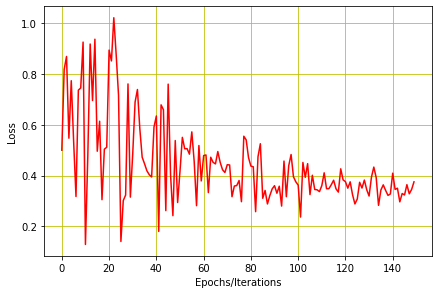

In [23]:
# 視覺化
plt.plot(loss_list, 'r')
plt.tight_layout()
plt.grid('True', color='y')
plt.xlabel("Epochs/Iterations")
plt.ylabel("Loss")
plt.show()

## 測試模型

In [44]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for datas, labels in val_loader:
        outputs = model(datas)
        _, predictions = torch.max(outputs, 1)
        n_samples += labels.shape[0]
        n_correct += (predictions == labels.reshape(-1)).sum().item()
    acc = 100.0 * n_correct / n_samples
    print(f'accuracy = {acc}%')

accuracy = 56.0%
